# Importance of known positives versus known negatives

In this notebook we will show how to compute performance curves (ROC and PR curves to be specific) based on a data set with known positives, known negatives and unlabeled data. We will show how to use our approach starting from known negatives instead of known positives, which is useful of the number of known negatives is much larger.

This notebook is intended to enable you to easily change the configuration of experiments, so feel free to make modifications where you see fit to see their effect.

In [1]:
import random
import operator as op
import optunity.metrics
import semisup_metrics as ss
import numpy as np
from matplotlib import pyplot as plt
import pickle
import csv
import util
%matplotlib inline

# Create or load data set
Generate simulated data. Feel free to configure the code below as you please.

In [2]:
# fraction of positives/negatives that are known
# known_neg_frac == 0 implies PU learning
known_pos_frac = 0.05
known_neg_frac = 0.5

# if you simulate a smaller data set you can see some effects better
# but estimated bounds will be much wider
# because the ECDF confidence interval becomes large
num_pos = 10000  
num_neg = 10000 
distid = 2  # can be 1, 2 or 3, these correspond to certain curves in ROC space

# generate rankings and label vectors and compute corresponding beta
# beta is based on known_pos_frac, known_neg_frac and the number of pos and negs
# labels is a list of {True, False, None}, where None indicates unlabeled
# true_labels is a list of {True, False}
labels, true_labels, decision_values, beta = util.simulate_data(distid, num_pos, num_neg,
                                                                known_pos_frac,
                                                                known_neg_frac)

## Data set characteristics

Known parameters:

In [3]:
print('total number of instances: \t %d' % len(labels))
print('number of known positives: \t %d' % len(list(filter(lambda x: x == True, labels))))
print('number of known negatives: \t %d' % len(list(filter(lambda x: x == False, labels))))
print('number of unlabeled instances: \t %d' % len(list(filter(lambda x: x == None, labels))))

total number of instances: 	 20000
number of known positives: 	 500
number of known negatives: 	 5000
number of unlabeled instances: 	 14500


Unknown parameters:

In [4]:
print('number of latent positives: \t %d' % len(list(filter(lambda x: x[0] == None and x[1] == True, zip(labels, true_labels)))))
print('number of latent negatives: \t %d' % len(list(filter(lambda x: x[0] == None and x[1] == False, zip(labels, true_labels)))))
print('beta: \t %1.4f' % beta)

number of latent positives: 	 9500
number of latent negatives: 	 5000
beta: 	 0.6552


# Estimate beta

As this notebook is intended to show the effect of known positives vs known negatives, we will continue with the true value of beta. Change this parameter to see its effect in the figures later on.

In [5]:
betahat = beta

print('true value of beta\t%1.4f' % beta)
print('point estimate of beta\t%1.4f' % betahat)

true value of beta	0.6552
point estimate of beta	0.6552


# 1. Compute cumulative rank distribution of known positives

We start by computing the rank CDF of known positives, and then determine a confidence interval for it. We will use a standard bootstrap approach.

In [6]:
# sort the labels in descending order of corresponding decision values
sort_labels, sort_dv, sort_true_labels = zip(*sorted(zip(labels, decision_values, true_labels),
                                                     key=op.itemgetter(1), reverse=True))

# ranks of the known positives
known_pos_ranks = [idx for idx, lab in enumerate(sort_labels) if lab]

# compute rank ECDF of known positives
known_pos_ecdf = ss.compute_ecdf_curve(known_pos_ranks)

Next, we determine a confidence interval on the rank CDF of known positives. We can do this in several ways, our code provides a bootstrap approach and a method based on the Dvoretzky–Kiefer–Wolfowitz (DKW) inequality. Feel free to experiment.

In [7]:
ci_width = 0.95      # width of the confidence band on ECDF to be used
use_bootstrap = True # use bootstrap to compute confidence band
nboot = 2000         # number of bootstrap iterations to use, not used if use_bootstrap = False

if use_bootstrap:
    pos_cdf_bounds = ss.bootstrap_ecdf_bounds(labels, decision_values, nboot=nboot, ci_width=ci_width)
else:
    pos_cdf_bounds = ss.dkw_bounds(labels, decision_values, ci_width=ci_width)

For reference, we will also compute the rank ECDF of latent positives. In practical applications this is impossible, as the latent positives are by definition not known.

In [8]:
latent_positives = map(lambda x, y: x == True and y == None, true_labels, labels)
sort_lps, _ = zip(*sorted(zip(latent_positives, decision_values),
                          key=op.itemgetter(1), reverse=True))
latent_pos_ranks = [idx for idx, lab in enumerate(sort_lps) if lab]
latent_pos_ecdf = ss.compute_ecdf_curve(latent_pos_ranks)

Plot the rank CDFs of known and latent positives. It may occur that the rank CDF of latent positives is not within the confidence interval of known positives, in which case the corresponding bounds on performance will not be strict.

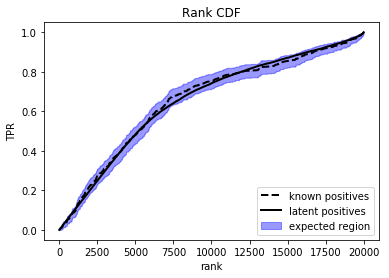

In [9]:
# convenience plot functions
def plot_proxy(color, alpha):
    p = plt.Rectangle((0, 0), 0, 0, color=color, alpha=alpha)
    ax = plt.gca()
    ax.add_patch(p)
    return p

def fix_plot_shape(fig):
    ax = fig.add_subplot(111, aspect='equal')
    axes = fig.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])

xs = list(range(len(labels)))
plt.figure(1)
plt.fill_between(xs, list(map(pos_cdf_bounds.lower, xs)), list(map(pos_cdf_bounds.upper, xs)), 
                 color='blue', alpha=0.4)
plt.plot(*zip(*known_pos_ecdf), color='black', linestyle='dashed', linewidth=2)
plt.plot(*zip(*latent_pos_ecdf), color='black', linewidth=2)
plot_proxy('blue', 0.4)
plt.xlabel('rank')
plt.ylabel('TPR')
plt.legend(['known positives', 'latent positives', 'expected region'], loc=4)
plt.title('Rank CDF')
plt.show()

# 2. Compute cumulative rank distribution of known negatives

The code below is analogous to what we did earlier for known positives, but now for known negatives. We will first flip known class labels, as described in the text.

In [10]:
# ranks of the known positives
known_neg_ranks = [idx for idx, lab in enumerate(sort_labels) if lab == False]

# compute rank ECDF of known positives
known_neg_ecdf = ss.compute_ecdf_curve(sorted(known_neg_ranks))

# flip class labels
labels_flipped = [not label if label is not None else None for label in labels]
sort_labels_flipped = [not label if label is not None else None for label in sort_labels]

# compute confidence interval in the same way as we did for known positives
if use_bootstrap:
    neg_cdf_bounds = ss.bootstrap_ecdf_bounds(labels_flipped, decision_values, nboot=nboot, ci_width=ci_width)
else:
    neg_cdf_bounds = ss.dkw_bounds(labels_flipped, decision_values, ci_width=ci_width)
    
# for reference, rank CDF of latent negatives
latent_negatives = map(lambda x, y: x == False and y == None, true_labels, labels)
sort_lns, _ = zip(*sorted(zip(latent_negatives, decision_values),
                          key=op.itemgetter(1), reverse=True))
latent_neg_ranks = [idx for idx, lab in enumerate(sort_lns) if lab]
latent_neg_ecdf = ss.compute_ecdf_curve(latent_neg_ranks)

Plot rank CDFs of known positives and known negatives along with their CIs.

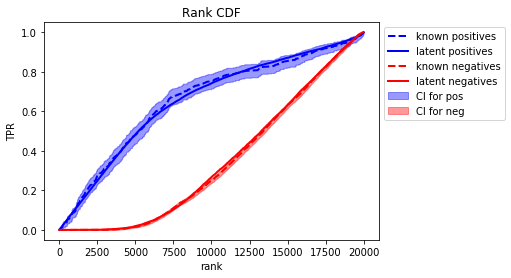

In [11]:
xs = list(range(len(labels)))
plt.figure(1)
plt.fill_between(xs, list(map(pos_cdf_bounds.lower, xs)), list(map(pos_cdf_bounds.upper, xs)), 
                 color='blue', alpha=0.4)
plt.plot(*zip(*known_pos_ecdf), color='blue', linestyle='dashed', linewidth=2)
plt.plot(*zip(*latent_pos_ecdf), color='blue', linewidth=2)
plot_proxy('blue', 0.4)

plt.fill_between(xs, list(map(neg_cdf_bounds.lower, xs)), list(map(neg_cdf_bounds.upper, xs)), 
                 color='red', alpha=0.4)
plt.plot(*zip(*known_neg_ecdf), color='red', linestyle='dashed', linewidth=2)
plt.plot(*zip(*latent_neg_ecdf), color='red', linewidth=2)
plot_proxy('red', 0.4)
plt.xlabel('rank')
plt.ylabel('TPR')
plt.legend(['known positives', 'latent positives', 'known negatives', 'latent negatives', 'CI for pos', 'CI for neg'], 
           loc="upper left", bbox_to_anchor=(1,1))
plt.title('Rank CDF')

plt.show()

# 3. Compute contingency tables for each rank
We will compute contingency tables based on the rank distribution of known positives and based on the rank distribution of known negatives.

Applying our approach to known negatives requires a few modifications:
1. Flip known class labels, so negatives become positives
2. Modify beta (new beta = 1 - beta)
3. Run our approach
4. Adjust resulting contingency tables (i.e., flip class labels back). Note also that the optimistic contingency table becomes the pessimistic table when flipping labels and vice versa.

In [12]:
# compute contingency tables based on CI of rank CDF of known positives
tables_pos = ss.compute_contingency_tables(labels=sort_labels, decision_values=sort_dv,
                                             reference_lb=pos_cdf_bounds.lower,
                                             reference_ub=pos_cdf_bounds.upper,
                                             beta=betahat, presorted=True)

# compute contingency tables based on CI of rank CDF of known negatives
# this requires flipping labels, changing beta and post-processing the resulting contingency tables
betahat_flipped = 1.0 - betahat
tables_neg = ss.compute_contingency_tables(labels=sort_labels_flipped, decision_values=sort_dv,
                                           reference_lb=neg_cdf_bounds.lower,
                                           reference_ub=neg_cdf_bounds.upper,
                                           beta=betahat_flipped, presorted=True)
postprocess_ct = lambda ct: ss.ContingencyTable(TP=ct.FP,
                                                FP=ct.TP,
                                                TN=ct.FN,
                                                FN=ct.TN)
tables_neg_post = ss._lb_ub(lower=list(map(postprocess_ct, tables_neg.upper)),
                            upper=list(map(postprocess_ct, tables_neg.lower)))

# 4. Compute and plot performance estimates based on the contingency tables

## 4.1 ROC curves

Start off with the easy stuff: the true ROC curve (unknown in practice), and the curve we obtain by assuming beta=0.

In [13]:
# compute the true ROC curve (we use Optunity's ROC function)
_, roc_true = optunity.metrics.roc_auc(true_labels, decision_values, return_curve=True)

Compute bounds based on the proposed method.

In [14]:
# we can directly use the contingency tables we already computed anyways
roc_bounds = lambda tables: ss._lb_ub(lower=ss.roc_from_cts(tables.lower),
                                      upper=ss.roc_from_cts(tables.upper))

# bounds starting from known positives
roc_bounds_pos = roc_bounds(tables_pos)

# bounds starting from known negatives
roc_bounds_neg = roc_bounds(tables_neg_post)

Plot the resulting curves

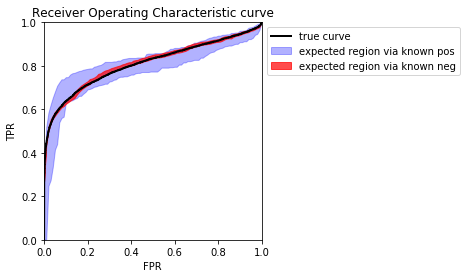

In [15]:
xs = [float(x) / 100 for x in range(101)]
roc_pos_up = ss.zoh(*zip(*roc_bounds_pos.upper))
roc_pos_lo = ss.zoh(*zip(*roc_bounds_pos.lower))
roc_neg_up = ss.zoh(*zip(*roc_bounds_neg.upper))
roc_neg_lo = ss.zoh(*zip(*roc_bounds_neg.lower))
fig = plt.figure(2)
fix_plot_shape(fig)
plt.plot(*zip(*roc_true), color='black', linewidth=2)
plt.fill_between(xs, list(map(roc_pos_lo, xs)), list(map(roc_pos_up, xs)), color='blue', alpha=0.3)
plt.fill_between(xs, list(map(roc_neg_lo, xs)), list(map(roc_neg_up, xs)), color='red', alpha=0.7)
plot_proxy('blue', 0.3)
plot_proxy('red', 0.7)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['true curve', 'expected region via known pos', 'expected region via known neg'],
           loc="upper left", bbox_to_anchor=(1,1))
plt.title('Receiver Operating Characteristic curve')
plt.show()

The resulting curves show clearly that in this case computing bounds based on known negatives is better, because we have far more known negatives.

## 4.2 PR curves

In [16]:
# we can directly use the contingency tables we already computed anyways
pr_bounds = lambda tables: ss._lb_ub(lower=ss.pr_from_cts(tables.lower),
                                     upper=ss.pr_from_cts(tables.upper))
pr_bounds_pos = pr_bounds(tables_pos)
pr_bounds_neg = pr_bounds(tables_neg_post)

# an alternative without all these intermediate steps would be:
# roc_bounds_point = ss.roc_bounds(labels, decision_values, beta=betahat)

# compute the true ROC curve (we use Optunity's ROC function)
_, pr_true = optunity.metrics.pr_auc(true_labels, decision_values, return_curve=True)

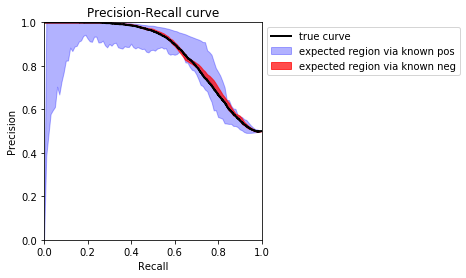

In [17]:
pr_pos_up = ss.zoh(*zip(*pr_bounds_pos.upper))
pr_pos_lo = ss.zoh(*zip(*pr_bounds_pos.lower))
pr_neg_up = ss.zoh(*zip(*pr_bounds_neg.upper))
pr_neg_lo = ss.zoh(*zip(*pr_bounds_neg.lower))
fig = plt.figure(3)
fix_plot_shape(fig)
plt.plot(*zip(*pr_true), color='black', linewidth=2)
plt.fill_between(xs, list(map(pr_pos_lo, xs)), list(map(pr_pos_up, xs)), color='blue', alpha=0.3)
plt.fill_between(xs, list(map(pr_neg_lo, xs)), list(map(pr_neg_up, xs)), color='red', alpha=0.7)
plot_proxy('blue', 0.3)
plot_proxy('red', 0.7)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['true curve', 'expected region via known pos', 'expected region via known neg'],
           loc="upper left", bbox_to_anchor=(1,1))
plt.title('Precision-Recall curve')
plt.show()